Reference paper: [Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin. 2003. A Neural Probabilistic Language Model. J. Mach. Learn. Res. 3, (February 2003), 1137–1155.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

One main difference in our implementation is that we are working with characters instead of words. The vocabulary size in the Bengio's paper is 17,000 words, whereas we are going to have a vocabulary of 27 characters (26 characters and the `<.>` special character).

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("./names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
s2i = {s: i + 1 for i, s in enumerate(chars)}
s2i["."] = 0
i2s = {i: s for s, i in s2i.items()}
print(i2s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        print("".join(i2s[i] for i in context), "--->", i2s[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
(
    X.shape,
    X.dtype,
    Y.shape,
    Y.dtype,
)

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
C = torch.randn((27, 2))  # embeddig matrix

We can index this embedding matrix directly...

In [8]:
C[5]

tensor([-1.0183,  1.0021])

Or using a multiplication between a OHE vector and the embedding matrix...

In [9]:
ohe = F.one_hot(torch.tensor(5), 27).float()  # F.one_hot() return int64 dtype tensors
ohe @ C

tensor([-1.0183,  1.0021])

In [10]:
emb = C[X]
emb.shape  # bs, ctx len, emb lengh

torch.Size([32, 3, 2])

In [11]:
W1 = torch.randn((6, 100))  # (ctx len x emb length), hidden dim
b1 = torch.randn(100)

In [12]:
# we would like to perform (emb @ W1) + b1, but the dims don't match
# ---------------------------------------------------------------------------
# RuntimeError                              Traceback (most recent call last)
# Cell In[31], line 1
# ----> 1 (emb @ W1) + b1

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)e

To solve this problem, we want to multiply between a matrix of shape `(32, 6)` and one of shape `(6, 100)`. One way to achieve this issue is to use `torch.cat()` and "manually" concatenate the embedding representation for each token in the input context.

In [13]:
%%timeit
(torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1) @ W1) + b1  # we need to concatenate 

28.9 µs ± 81.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The issue with this approach is that it won't automatically handle increasing/decreasing the context length. 

Alternatively, we could use `torch unbind()`. This command will return a tuple of all slices along a given dimension, already without it.

In [14]:
a = torch.unbind(emb, 1)
len(a)

3

In [15]:
%%timeit 
(torch.cat(torch.unbind(emb, 1), 1) @ W1) + b1

16.9 µs ± 56.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


One downside of using `torch.cat()` is that we are creating an entirely new tensor in memory.

An even more efficient way of doing this is to use the `.view()` method. In each tensor, there is an undelying storage, that we can access with `Tensor.storage()`, which contains all of the numbers in a tensor as a 1-dimensional vector. This in how the tensor is represented in memory ― a 1D vector. When we call `.view()`, we are manipulating some attributes (i.e., offset, stride, and shape) of that tensor, that dictate how this 1D sequence is interpreted to be as a N-dimensional tensor. When we use `.view()`, no memory is being moved, copied, or created. The storage stays the same. 

In [16]:
%%timeit
(emb.view((32, -1)) @ W1) + b1

7.8 µs ± 30.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Another approach, more readable and also performant is to use `.reshape()`. As [this StackOverflow answer](https://stackoverflow.com/a/54507446/2092449) very clearly explains, the difference between `.view()` and `.reshape()` is that the latter might return a new tensor that may be a view of the original tensor, or it may be a new tensor altogether. So, if you just want to reshape tensors, use `.reshape()`. If you're also concerned about memory usage and want to ensure that the two tensors share the same data, use `.view()`.

In [17]:
%%timeit
(emb.reshape((32, -1)) @ W1) + b1

7.9 µs ± 31 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


I suggest to use `view()` whenever possible, for performance reasons.

In [18]:
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
h

tensor([[-0.3733, -0.3367, -0.1093,  ..., -0.7480, -0.9814, -0.9784],
        [ 0.9697, -0.9851,  0.9336,  ..., -0.8036, -0.7131, -1.0000],
        [-0.9453,  0.9108,  0.9976,  ..., -0.8728,  0.8644,  0.9003],
        ...,
        [ 0.7043, -0.4071,  0.9782,  ..., -0.2805, -0.2738, -0.9826],
        [ 0.8992,  0.9788, -0.9462,  ...,  0.5092, -0.6950, -0.0664],
        [-1.0000, -0.9968, -0.8004,  ..., -0.9638,  0.9989,  0.9915]])

In [19]:
h.shape

torch.Size([32, 100])

One thing to pay attention to, is the addition operation. The resulting matrix generated by multiplying `emb` (reshaped) and `W1` is of size `(32, 100)`, whilst the bias vector has size `(100)`.

```
32, 100 --> 32, 100
    100 -->  1, 100
```

So the same bias vector will be copied to all the rows of the (`emb.view(emb.shape[0], -1) @ W1`) matrix. Meaning that element `b[0, 0]` will be added to each element of the row `x[0, :]`.

In [20]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([32, 27])

In [23]:
counts = logits.exp()

In [24]:
probs = counts / counts.sum(1, keepdims=True)

In [25]:
probs.shape

torch.Size([32, 27])

In [26]:
# sanity check, rows should sum to 1
probs[0].sum()

tensor(1.0000)

In [27]:
loss = -probs[torch.arange(32), Y].log().mean()  # average neg log likelihood
loss

tensor(13.7568)

Let's rewrite all of the above in a more reusable way, and train the MLP model

In [28]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [29]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

How can we find a good startint point for the learning rate?

In [30]:
lre = []
lrs = []
tracker = []
steps = 1_000

for e in torch.linspace(-3, 0, steps):
    lrs.append(10**e)
    lre.append(e)
    
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g).requires_grad_()
W1 = torch.randn((6, 100), generator=g).requires_grad_()
b1 = torch.randn((100), generator=g).requires_grad_()
W2 = torch.randn((100, 27), generator=g).requires_grad_()
b2 = torch.randn((27), generator=g).requires_grad_()
parameters = [C, W1, b1, W2, b2]
bs = 32

for step in range(steps):
    # minibatch
    ix = torch.randint(0, X.shape[0], (bs,))
    xs = X[ix]
    ys = Y[ix]
    lr = lrs[step]

    # forward pass
    emb = C[xs]  # (32, 3, 2)
    h = torch.tanh(
        emb.view((-1, 6)) @ W1 + b1
    )  # (32, 100)... also tanh is important to not get inf loss!
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, ys)

    if step % 10 == 0:
        print(f"step {step}: {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data -= lr * p.grad
        
    tracker.append(loss.item())

step 0: 20.520742416381836
step 10: 15.709940910339355
step 20: 18.65235710144043
step 30: 19.184219360351562
step 40: 18.97753143310547
step 50: 17.87656593322754
step 60: 16.9854736328125
step 70: 17.939760208129883
step 80: 15.722808837890625
step 90: 15.315943717956543
step 100: 14.567620277404785
step 110: 15.001252174377441
step 120: 16.64520835876465
step 130: 17.108299255371094
step 140: 16.85639762878418
step 150: 16.003313064575195
step 160: 17.57159423828125
step 170: 12.908891677856445
step 180: 14.073016166687012
step 190: 13.801885604858398
step 200: 11.809076309204102
step 210: 13.443002700805664
step 220: 11.984759330749512
step 230: 13.750946044921875
step 240: 14.751912117004395
step 250: 10.859346389770508
step 260: 9.701944351196289
step 270: 13.113263130187988
step 280: 13.338791847229004
step 290: 10.742907524108887
step 300: 8.724717140197754
step 310: 12.030903816223145
step 320: 11.712464332580566
step 330: 9.133163452148438
step 340: 10.498455047607422
step 35

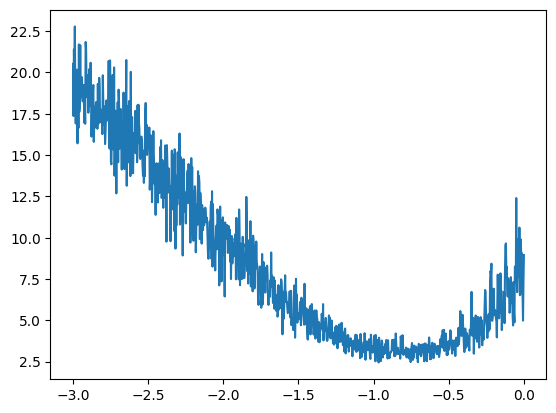

In [31]:
plt.plot(lre, tracker)

Using the LR Finder first proposed by [Leslie Smith](https://arxiv.org/abs/1506.01186), $ 10^{-1} $ seems like a good starting point.

In [55]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g).requires_grad_()
W1 = torch.randn((6, 100), generator=g).requires_grad_()
b1 = torch.randn((100), generator=g).requires_grad_()
W2 = torch.randn((100, 27), generator=g).requires_grad_()
b2 = torch.randn((27), generator=g).requires_grad_()
parameters = [C, W1, b1, W2, b2]

In [56]:
sum(p.nelement() for p in parameters)

3481

In [57]:
bs = 32
lr = 10**-1

for step in range(5_000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (bs,))
    xs = X[ix]
    ys = Y[ix]

    # forward pass
    emb = C[xs]  # (32, 3, 2)
    h = torch.tanh(
        emb.view((-1, 6)) @ W1 + b1
    )  # (32, 100)... also tanh is important to not get inf loss!
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, ys)

    if step % 250 == 0:
        print(f"epoch {step}: {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if step == 4_000:
        lr = lr / 10
    for p in parameters:
        p.data -= lr * p.grad

epoch 0: 21.285463333129883
epoch 250: 2.779158115386963
epoch 500: 2.7999091148376465
epoch 750: 2.9286704063415527
epoch 1000: 2.732006549835205
epoch 1250: 2.4961163997650146
epoch 1500: 2.803800344467163
epoch 1750: 2.5853960514068604
epoch 2000: 2.9869768619537354
epoch 2250: 2.4019172191619873
epoch 2500: 2.8153340816497803
epoch 2750: 2.7604598999023438
epoch 3000: 2.7406837940216064
epoch 3250: 2.374897003173828
epoch 3500: 2.639711618423462
epoch 3750: 2.7565231323242188
epoch 4000: 2.4598326683044434
epoch 4250: 2.5725317001342773
epoch 4500: 2.730372190475464
epoch 4750: 2.3899929523468018


This model might be slightly better than the bigram model, since we are reaching a lower training loss. We should however use a validation loss/metric to have definitive results.